# Objected-Oriented Simulation

Up to this point we have been using Python generators and shared resources as the building blocks for simulations of complex systems. This can be  effective, particularly if the individual agents do not require access to the internal state of other agents. But there are situations where the action of an agent depends on the state or properties of another agent in the simulation. For example, consider this discussion question from the Grocery store checkout example:

>Suppose we were to change one or more of the lanes to a express lanes which handle only with a small number of items, say five or fewer. How would you expect this to change average waiting time? This is a form of prioritization ... are there other prioritizations that you might consider?

The customer action depends the item limit parameter associated with a checkout lane. This is a case where the action of one agent depends on a property of another. The shared resources builtin to the SimPy library provide some functionality in this regard, but how do add this to the simulations we write?

The good news is that Python offers a rich array of object oriented programming features well suited to this purpose. The SymPy documentation provides excellent examples of how to create Python objects for use in SymPy. The bad news is that object oriented programming in Python -- while straightforward compared to many other programming languages -- constitutes a steep learning curve for students unfamiliar with the core concepts.

Fortunately, since the introduction of Python 3.7 in 2018, the standard libraries for Python have included a simplified method for creating and using Python classes. Using [dataclass](https://realpython.com/python-data-classes/), it easy to create objects for SymPy simulations that retain the benefits of object oriented programming without all of the coding overhead. 

The purpose of this notebook is to introduce the use of `dataclass` in creating SymPy simulations. To the best of the author's knowledge, this is a novel use of `dataclass` and the only example of which the author is aware.

## Installations and imports

In [91]:
!pip install sympy

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import pandas as pd
from dataclasses import dataclass

In [128]:
import sys
print(sys.version)

3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


Additional imports are from the `dataclasses` library that has been part of the standard Python distribution since version 3.7. Here we import `dataclass` and `field`.

In [93]:
from dataclasses import dataclass, field

## Introduction to `dataclass`

Tutorials and additional documentation:

* [The Ultimate Guide to Data Classes in Python 3.7](https://realpython.com/python-data-classes/):  Tutorial article from ReaalPython.com
* [dataclasses — Data Classes](https://docs.python.org/3/library/dataclasses.html):  Official Python documentation.
* [Data Classes in Python](https://towardsdatascience.com/data-classes-in-python-8d1a09c1294b): Tutorial from TowardsDataScience.com

### Creating a `dataclass`

A `dataclass` defines a new class of Python objects. A `dataclass` object takes care of several routine things that you would otherwise have to code, such as creating instances of an object, testing for equality, and other aspects. 

As an example, the following cell shows how to define a dataclass corresponding to a hypothetical Student object. The Student object maintains data associated with instances of a student. The dataclass also defines a function associated with the object.

In [94]:
from dataclasses import dataclass

@dataclass
class Student():
    name: str
    graduation_class: int
    dorm: str
        
    def print_name(self):
        print(f"{self.name} (Class of {self.graduation_class})")

Let's create an instance of the Student object.

In [95]:
sam = Student("Sam Jones", 2024, "Alumni")

Let's see how the `print_name()` function works.

In [96]:
sam.print_name()

Sam Jones (Class of 2024)


The next cell shows how to create a list of students, and how to iterate over a list of students.

In [97]:
# create a list of students
students = [
    Student("Sam Jones", 2024, "Alumni"),
    Student("Becky Smith", 2023, "Howard"),
]

# iterate over the list of students to print all of their names
for student in students:
    student.print_name()
    print(student.dorm)

Sam Jones (Class of 2024)
Alumni
Becky Smith (Class of 2023)
Howard


Here are a few details you need to use `dataclass` effectively:

* The `class` statement is standard statement for creating a new class of Python objects. The preceding `@dataclass` is a Python 'decorator'. Decorators are Python functions that modify the behavior of subsequent statements. In this case, the `@dataclass` decorator modifies `class` to provide a streamlined syntax for implementing classes.
* A Python class names begin with a capital letter. In this case `Student` is the class name.
* The lines following the the class statement declare parameters that will be used by the new class. The parameters can be specified when you create an instance of the dataclass. 
* Each paraameter is followed by type 'hint'.  Commonly used type hints are `int`, `float`, `bool`, and `str`. Use the keyword `any` you don't know or can't specify a particular type. Type hints are actually used by type-checking tools and ignored by the python interpreter.
* Following the parameters, write any functions or generators that you may wish to define for the new class. To access variables unique to an instance of the class, preceed the parameter name with `self`.

### Specifying parameter values

There are different ways of specifying the parameter values assigned to an instance of a dataclass. Here are three particular methods:

* Specify the parameter value when creating a new instance. This is what was done in the Student example above.
* Provide a default values determined when the dataclass is defined.
* Provide a default_factory method to create a parameter value when an instance of the dataclass is created.

#### Specifying a parameter value when creating a new instance

Parameter values can be specified when creating an instance of a dataclass. The parameter values can be specified by position or by name as shown below.

In [115]:
from dataclasses import dataclass

@dataclass
class Student():
    name: str
    graduation_year: int
    dorm: str
    
    def print_name(self):
        print(f"{self.name} (Class of {self.graduation_year})")
        
sam = Student("Sam Jones", 2031, "Alumni")
sam.print_name()

gilda = Student(name="Gilda Radner", graduation_year=2030, dorm="Howard")
gilda.print_name()

Sam Jones (Class of 2031)
Gilda Radner (Class of 2030)


#### Setting default parameter values

Setting a default value for a parameter can save extra typing or coding. More importantly, setting default values makes it easier to maintain and adapt code for other applications, and is a convenient way to handle missing data. 

There are two ways to set default parameter values. For str, int, float, bool, tuple (the immutable types in Python), a default value can be set using `=` as shown in the next cell.

In [99]:
from dataclasses import dataclass

@dataclass
class Student():
    name: str = None
    graduation_year: int = None
    dorm: str = None
    
    def print_name(self):
        print(f"{self.name} (Class of {self.graduation_year})")
        
jdoe = Student(name="John Doe", dorm="Alumni")
jdoe.print_name()

John Doe (Class of None)


Default parameter values are restricted to 'immutable' types. This technical restriction eliminiates the error-prone practice of use mutable objects, such as lists, as defaults. The difficulty with setting defaults for mutable objects is that all instances of the dataclass share the same value. If one instance of the object changes that value, then all other instances are affected. This leads to unpredictable behavior, and is a particularly nasty bug to uncover and fix.

There are two ways to provide defaults for mutable parameters such as lists, sets, dictionaries, or arbitrary Python objects. 

The more direct way is to specify a function for constucting the default parameter value using the `field` statement with the `default_factory` option. The default_factory is called when a new instance of the dataclass is created. The function must take no arguments and must return a value that will be assigned to the designated parameter. Here's an example.

In [117]:
from dataclasses import dataclass

@dataclass
class Student():
    name: str = None
    graduation_year: int = None
    dorm: str = None
    majors: list = field(default_factory=list)
    
    def print_name(self):
        print(f"{self.name} (Class of {self.graduation_year})")
        
    def print_majors(self):
        for n, major in enumerate(self.majors):
            print(f"    {n+1}. {major}")
        
jdoe = Student(name="John Doe", dorm="Alumni", majors=["Math", "Chemical Engineering"])
jdoe.print_name()
jdoe.print_majors()

Student().print_majors()

John Doe (Class of None)
    1. Math
    2. Chemical Engineering


#### Initializing a dataclass with __post_init__(self)

Frequently there are additional steps to complete when creating a new instance of a dataclass. For that purpose, a dataclass may contain an
optional function with the special name `__post_init__(self)`. If present, that function is run automatically following the creation of a new instance. This feature will be demonstrated in following reimplementation of the grocery store checkout operation.

## Using `dataclass` with Simpy

### Step 0. A simple model

To demonstrate the use of classes in SimPy simulations, let's begin with a simple model of a clock using generators.

In [176]:
import simpy

def clock(id="", t_step=1.0):
    while True:
        print(id, env.now)
        yield env.timeout(t_step)
        
env = simpy.Environment()
env.process(clock("A"))
env.process(clock("B", 1.5))
env.run(until=5.0)

A 0
B 0
A 1.0
B 1.5
A 2.0
B 3.0
A 3.0
A 4.0
B 4.5


### Step 1. Embed the generator inside of a class

As a first step, we rewrite the generator as a Python dataclass named `Clock`. The parameters are given default values, and the generator is incorporated within the Clock object. Note the use of `self` to refer to parameters specific to an instance of the class.

In [181]:
import simpy
from dataclasses import dataclass

@dataclass
class Clock():
    id: str = ""
    t_step: float = 1.0
    
    def process(self):
        while True:
            print(self.id, env.now)
            yield env.timeout(self.t_step)

env = simpy.Environment()
env.process(Clock("A").process())
env.process(Clock("B", 1.5).process())
env.run(until=5)

A 0
B 0
A 1.0
B 1.5
A 2.0
B 3.0
A 3.0
A 4.0
B 4.5


### Step 2. Eliminate (if possible) global variables

Our definition of clock requires the simulation environment to have a specific name `env`, and assumes env is a global variable. That's generally not a good coding practice because it imposes an assumption on any user of the class, and exposes the internal coding of the class. A much better practice is to use class parameters to pass this data through a well defined interface to the class.

In [186]:
import simpy
from dataclasses import dataclass

@dataclass
class Clock():
    env: simpy.Environment
    id: str = ""
    t_step: float = 1.0
    
    def process(self):
        while True:
            print(self.id, self.env.now)
            yield self.env.timeout(self.t_step)

env = simpy.Environment()
env.process(Clock(env, "A").process())
env.process(Clock(env, "B", 1.5).process())
env.run(until=10)

A 0
B 0
A 1.0
B 1.5
A 2.0
B 3.0
A 3.0
A 4.0
B 4.5
A 5.0
B 6.0
A 6.0
A 7.0
B 7.5
A 8.0
B 9.0
A 9.0


### Step 3. Encapsulate initializations inside __post_init__

In [185]:
import simpy
from dataclasses import dataclass

@dataclass
class Clock():
    env: simpy.Environment
    id: str = ""
    t_step: float = 1.0
        
    def __post_init__(self):
        self.env.process(self.process())
    
    def process(self):
        while True:
            print(self.id, self.env.now)
            yield self.env.timeout(self.t_step)

env = simpy.Environment()
Clock(env, "A")
Clock(env, "B", 1.5)
env.run(until=5)

A 0
B 0
A 1.0
B 1.5
A 2.0
B 3.0
A 3.0
A 4.0
B 4.5


## Grocery Store Model

Let's review our model for the grocery store checkout operations. There are multiple checkout lanes, each with potentially different characteristics. With generators we were able to implement differences in the time required to scan items. But another parameter, a limit on number of items that could be checked out in a lane, required a new global list. The reason was the need to access that parameter, something that a generator doesn't allow. This is where classes become important building blocks in creating more complex simulations.

Our new strategy will be encapsulate the generator inside of a dataclass object. Here's what we'll ask each class definition to do:

* Create a parameter corresponding to the simulation environment.  This makes our classes reusable in other simulations by eliminating a reference to a globall variable.
* Create parameters with reasonable defaults values.
* Initialize any objects used within the class.
* Register the class generator with the simulation environment.


In [173]:
from dataclasses import dataclass

# create simulation models
@dataclass
class Checkout():
    env: simpy.Environment
    lane: simpy.Store =  None
    t_item: float = 1/10
    item_limit: int = 25
    t_payment: float = 2.0
        
    def __post_init__(self):
        self.lane = simpy.Store(self.env)
        self.env.process(self.process())
    
    def process(self):
        while True:
            customer_id, cart, enter_time = yield self.lane.get()
            wait_time = env.now - enter_time
            yield env.timeout(self.t_payment + cart*self.t_item)
            customer_log.append([customer_id, cart, enter_time, wait_time, env.now]) 
            
@dataclass
class CustomerGenerator():
    env: simpy.Environment
    rate: float = 1.0
    customer_id: int = 1
        
    def __post_init__(self):
        self.env.process(self.process())
        
    def process(self):
        while True:
            yield env.timeout(random.expovariate(self.rate))
            cart = random.randint(1, 25)
            available_checkouts = [checkout for checkout in checkouts if cart <= checkout.item_limit]
            checkout = min(available_checkouts, key=lambda checkout: len(checkout.lane.items))
            yield checkout.lane.put([self.customer_id, cart, env.now])
            self.customer_id += 1

def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(checkout.lane.items) for checkout in checkouts])
        yield env.timeout(t_sample)
    
# create simulation environment
env = simpy.Environment()

# create simulation objects (agents)
CustomerGenerator(env)
checkouts = [
    Checkout(env, t_item=1/5, item_limit=25),
    Checkout(env, t_item=1/5, item_limit=25),
    Checkout(env, item_limit=5),
    Checkout(env),
    Checkout(env),
]
env.process(lane_logger())

# run process
customer_log = []
lane_log = []
env.run(until=600)

Average waiting time =  4.18 minutes

Average lane queue 
lane 0    1.406500
lane 1    1.192167
lane 2    0.050667
lane 3    0.840000
lane 4    0.635833
dtype: float64

Overall aaverage lane queue 
0.8250


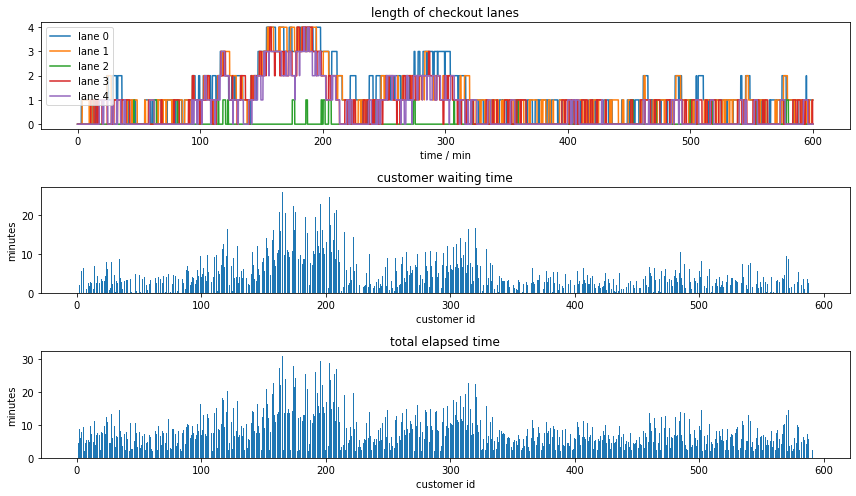

In [174]:
def visualize():

    # extract lane data
    lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, len(checkouts))])
    lane_df = lane_df.set_index("time")

    customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "wait", "leave"])
    customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

    # compute kpi's
    print(f"Average waiting time = {customer_df['wait'].mean():5.2f} minutes")
    print(f"\nAverage lane queue \n{lane_df.mean()}")
    print(f"\nOverall aaverage lane queue \n{lane_df.mean().mean():5.4f}")

    # plot results
    fig, ax = plt.subplots(3, 1, figsize=(12, 7))
    ax[0].plot(lane_df)
    ax[0].set_xlabel("time / min")
    ax[0].set_title("length of checkout lanes")
    ax[0].legend(lane_df.columns)

    ax[1].bar(customer_df["customer id"], customer_df["wait"])
    ax[1].set_xlabel("customer id")
    ax[1].set_ylabel("minutes")
    ax[1].set_title("customer waiting time")

    ax[2].bar(customer_df["customer id"], customer_df["elapsed"])
    ax[2].set_xlabel("customer id")
    ax[2].set_ylabel("minutes")
    ax[2].set_title("total elapsed time")
    plt.tight_layout()
    
visualize()

## Customers as agents

Average waiting time =  3.26 minutes

Average lane queue 
lane 0    1.080167
lane 1    0.954167
lane 2    0.063167
lane 3    0.590333
lane 4    0.362167
dtype: float64

Overall aaverage lane queue 
0.6100


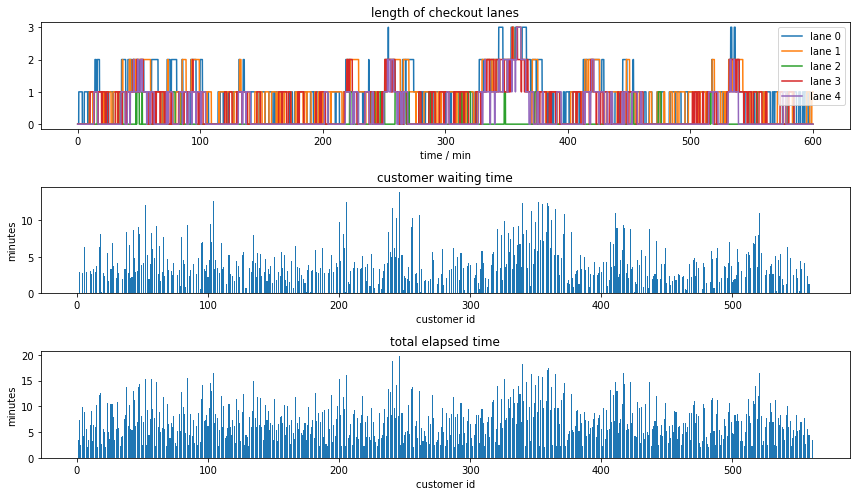

In [163]:
from dataclasses import dataclass

# create simulation models
@dataclass
class Checkout():
    env: simpy.Environment
    lane: simpy.Store =  None
    t_item: float = 1/10
    item_limit: int = 25
    t_payment: float = 2.0
        
    def __post_init__(self):
        self.lane = simpy.Store(self.env)
        self.env.process(self.process())
    
    def process(self):
        while True:
            customer_id, cart, enter_time = yield self.lane.get()
            wait_time = env.now - enter_time
            yield env.timeout(self.t_payment + cart*self.t_item)
            customer_log.append([customer_id, cart, enter_time, wait_time, env.now]) 
            
@dataclass
class CustomerGenerator():
    env: simpy.Environment
    rate: float = 1.0
    customer_id: int = 1
        
    def __post_init__(self):
        self.env.process(self.process())
        
    def process(self):
        while True:
            yield env.timeout(random.expovariate(self.rate))
            Customer(self.env, self.customer_id)
            self.customer_id += 1
            
@dataclass
class Customer():
    env: simpy.Environment
    id: int = 0
        
    def __post_init__(self):
        self.cart = random.randint(1, 25)
        self.env.process(self.process())
    
    def process(self):
        available_checkouts = [checkout for checkout in checkouts if self.cart <= checkout.item_limit]
        checkout = min(available_checkouts, key=lambda checkout: len(checkout.lane.items))
        yield checkout.lane.put([self.id, self.cart, env.now])
        

def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(checkout.lane.items) for checkout in checkouts])
        yield env.timeout(t_sample)
    
# create simulation environment
env = simpy.Environment()

# create simulation objects (agents)
CustomerGenerator(env)
checkouts = [
    Checkout(env, t_item=1/5, item_limit=25),
    Checkout(env, t_item=1/5, item_limit=25),
    Checkout(env, item_limit=5),
    Checkout(env),
    Checkout(env),
]
env.process(lane_logger())

# run process
customer_log = []
lane_log = []
env.run(until=600)

visualize()

## Creating Smart Objects


Average lane queue 
lane 0    1.167000
lane 1    0.937500
lane 2    0.056500
lane 3    0.615833
lane 4    0.317333
dtype: float64

Overall average lane queue 
0.6188


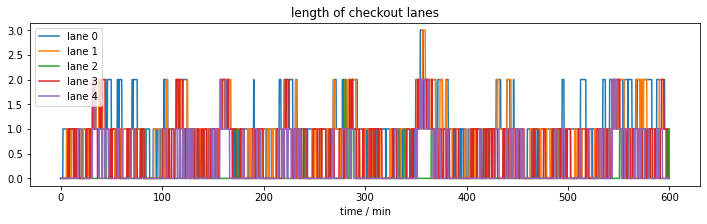

In [145]:
from dataclasses import dataclass, field
import pandas as pd

# create simulation models
@dataclass
class Checkout():
    lane: simpy.Store
    t_item: float = 1/10
    item_limit: int = 25
    
    def process(self):
        while True:
            customer_id, cart, enter_time = yield self.lane.get()
            wait_time = env.now - enter_time
            yield env.timeout(t_payment + cart*self.t_item)
            customer_log.append([customer_id, cart, enter_time, wait_time, env.now]) 
            
@dataclass
class CustomerGenerator():
    rate: float = 1.0
    customer_id: int = 1
        
    def process(self):
        while True:
            yield env.timeout(random.expovariate(self.rate))
            cart = random.randint(1, 25)
            available_checkouts = [checkout for checkout in checkouts if cart <= checkout.item_limit]
            checkout = min(available_checkouts, key=lambda checkout: len(checkout.lane.items))
            yield checkout.lane.put([self.customer_id, cart, env.now])
            self.customer_id += 1

@dataclass
class LaneLogger():
    lane_log: list = field(default_factory=list)  # this creates a variable that can be modified
    t_sample: float = 0.1
    lane_df: pd.DataFrame = field(default_factory=pd.DataFrame)
        
    def process(self):
        while True:
            self.lane_log.append([env.now] + [len(checkout.lane.items) for checkout in checkouts])
            yield env.timeout(self.t_sample)
            
    def report(self):
        self.lane_df = pd.DataFrame(self.lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
        self.lane_df = self.lane_df.set_index("time")
        print(f"\nAverage lane queue \n{self.lane_df.mean()}")
        print(f"\nOverall average lane queue \n{self.lane_df.mean().mean():5.4f}")
        
    def plot(self):
        self.lane_df = pd.DataFrame(self.lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
        self.lane_df = self.lane_df.set_index("time")       
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
        ax.plot(self.lane_df)
        ax.set_xlabel("time / min")
        ax.set_title("length of checkout lanes")
        ax.legend(self.lane_df.columns)  
        
# create simulation environment
env = simpy.Environment()

# create simulation objects (agents)
customer_generator = CustomerGenerator()
checkouts = [
    Checkout(simpy.Store(env), t_item=1/5),
    Checkout(simpy.Store(env), t_item=1/5),
    Checkout(simpy.Store(env), item_limit=5),
    Checkout(simpy.Store(env)),
    Checkout(simpy.Store(env)),
]
lane_logger = LaneLogger()

# register agents
env.process(customer_generator.process())
for checkout in checkouts:
    env.process(checkout.process())  
env.process(lane_logger.process())

# run process
env.run(until=600)

# plot results
lane_logger.report()
lane_logger.plot()